# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №3

## №1 (40 баллов)

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/daniilsobolev/Downloads/HW_003_001.txt')

In [3]:
df.sample(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
3044,NM,105,408,No,No,0,146.4,81,24.89,225.1,80,19.13,230.1,117,10.35,8.5,2,2.30,1,False
1541,MT,48,415,No,Yes,36,230.9,92,39.25,167.6,121,14.25,270.0,87,12.15,7.6,4,2.05,3,False
2459,HI,105,415,No,No,0,211.1,99,35.89,176.7,66,15.02,221.5,96,9.97,14.7,7,3.97,4,False
207,OR,38,415,No,No,0,194.4,94,33.05,186.7,95,15.87,223.3,90,10.05,10.8,5,2.92,3,False
2913,CA,185,408,No,No,0,139.6,92,23.73,250.2,115,21.27,158.1,79,7.11,10.8,4,2.92,1,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [5]:
df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})

df['Churn'] = df['Churn'].astype('int')

### EDA

#### Посмотрим на целевой 

In [6]:
df['Churn'].value_counts(normalize=True)

0    0.855086
1    0.144914
Name: Churn, dtype: float64

Видим, что есть дисбаланс классов. ~1:6

#### Далее посомтрим на распределения в зависимости от значения целевого

In [7]:
def plot_hist(data, columns):
    for column in columns: 
        plt.figure(figsize=(12,6))
        data[column].hist(alpha=0.7, bins=50)
        data[data['Churn'] == 1][column].hist(alpha=0.7, bins=50)
        plt.scatter(data[column].mean(), 10, linewidths=15, edgecolors='red', alpha=0.7)
        plt.scatter(data[data['Churn'] == 1][column].mean(), 10, linewidths=15, edgecolors='green', alpha=0.7)
        plt.legend(['Среднее по всем', 'Среднее по ушедшим', 'Все пользователи', 'Ушедшие'])
        plt.title(f'Гистограмма по признаку {column}')
        plt.ylabel('Количество пользователей')
        plt.show()

В первую очередь интересно посмотреть на те признаки, в которых значения бинарные:

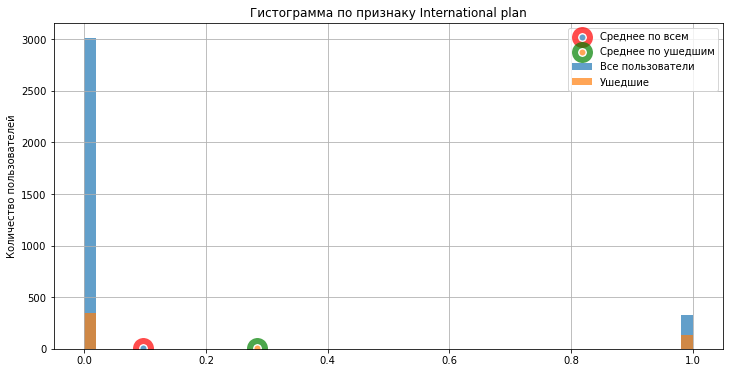

In [8]:
plot_hist(df, ['International plan'])

Можно выдвинуть гипотезу: 
- Пользователи с тарифом 'зарубежный' уходят чаще.

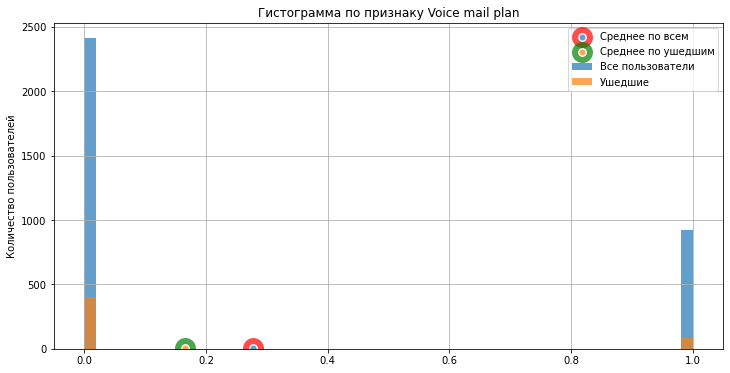

In [9]:
plot_hist(df, ['Voice mail plan'])

Тут же определенных зависимостей не наблюдается.

Далее смотрим на все остальные признаки:

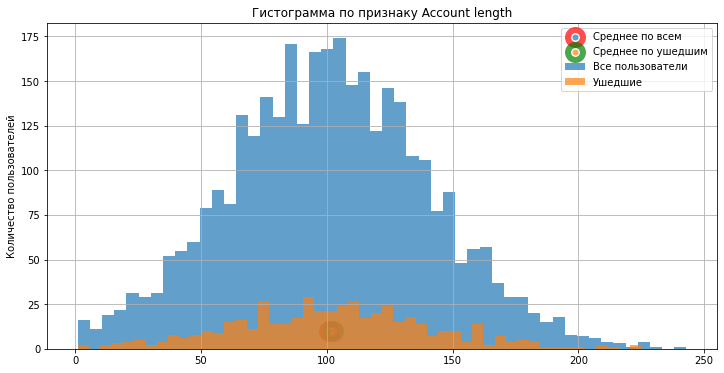

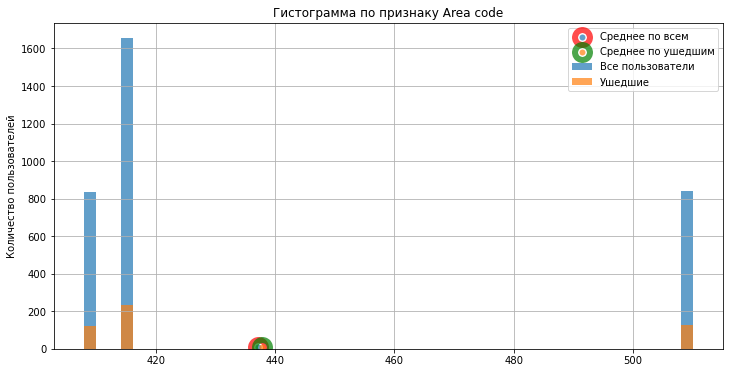

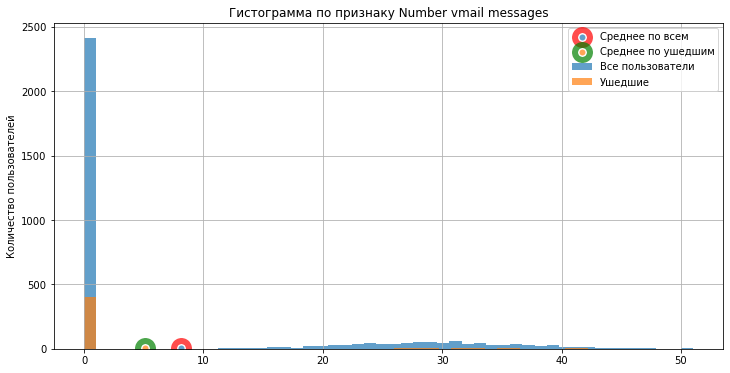

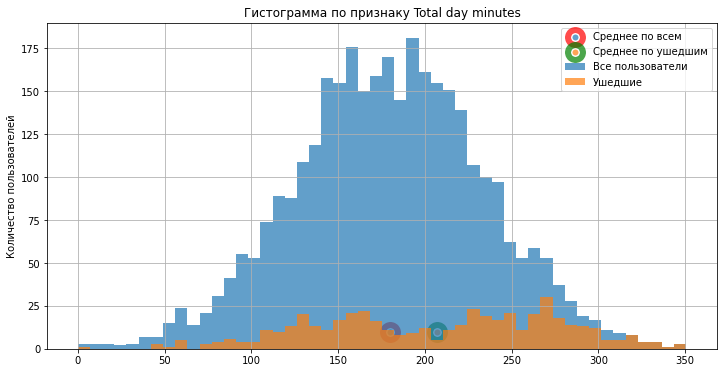

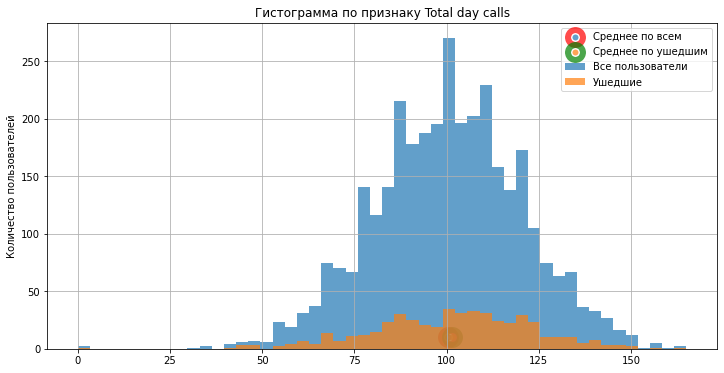

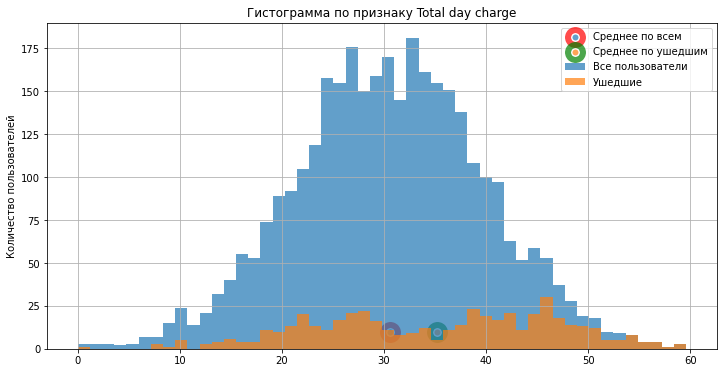

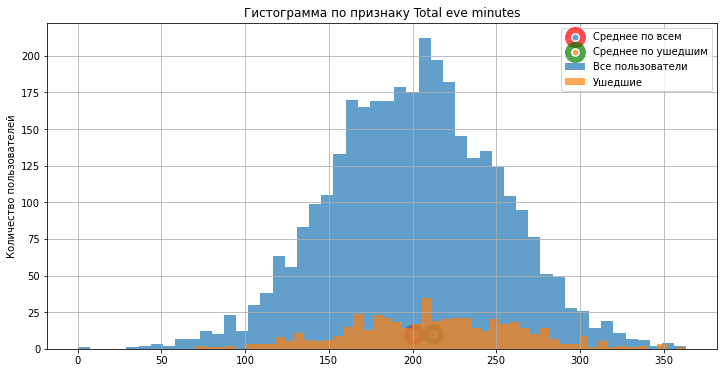

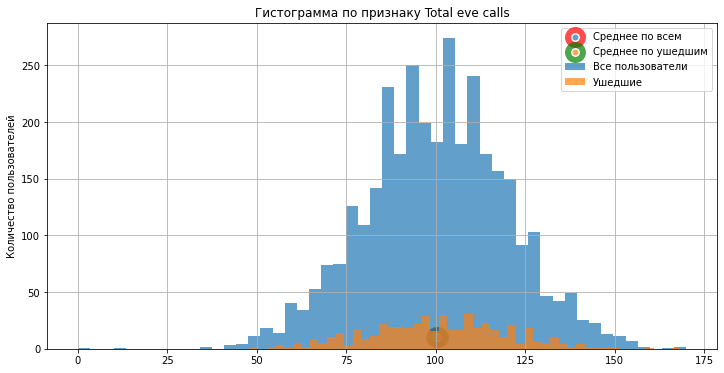

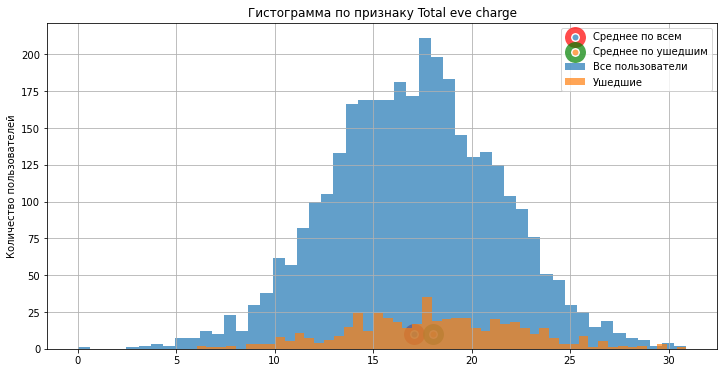

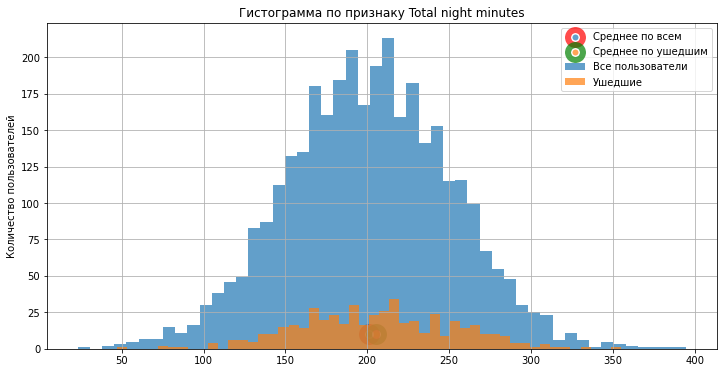

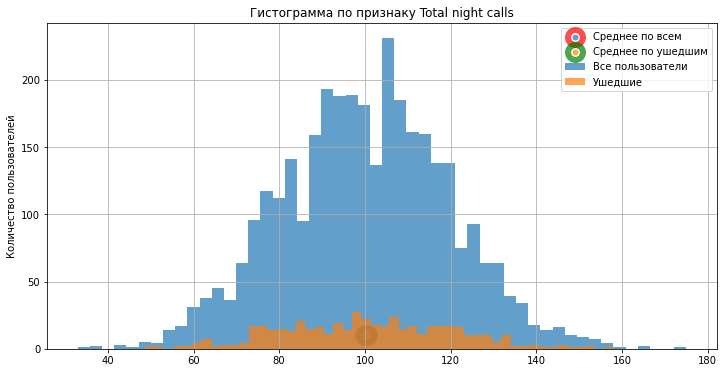

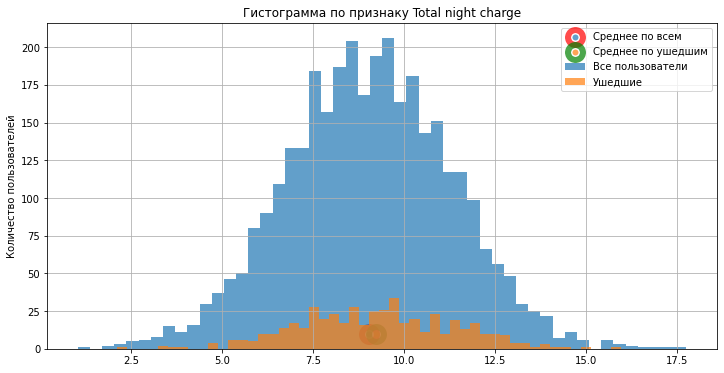

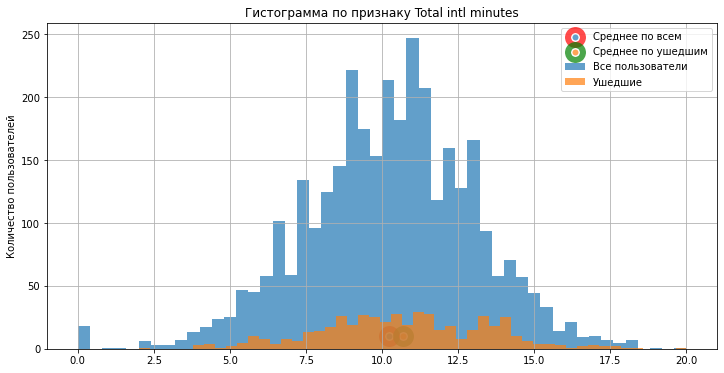

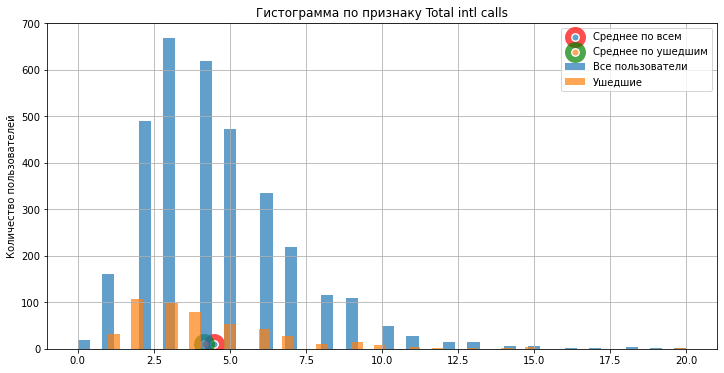

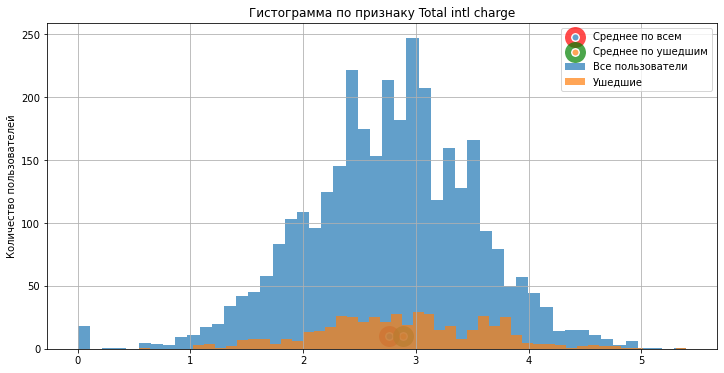

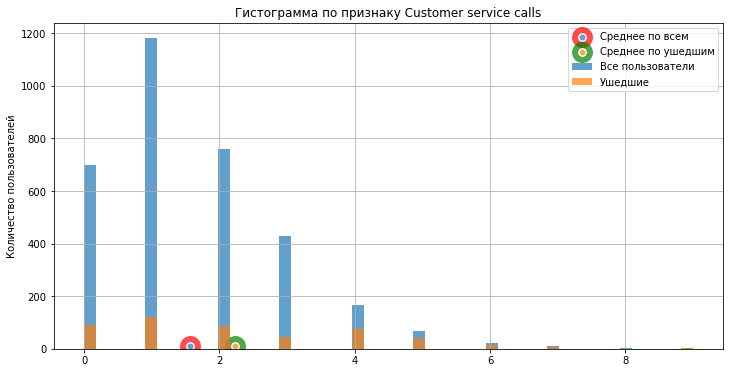

In [10]:
plot_hist(df, ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls'])

- Account length - непонятный признак и непонятно как его интерпретировать, но при этом зависимость одинакова для обеих групп.
- По Area Code тоже нет ничего выделяющегося.
- Для признака Number vmail messages требуется допонительное исследование - без нулевых значений.
- Есть гипотеза по признаку Total day minutes: Если пользователь говорил в день по телеыфону много боольше среднего, то он уходи от нас. Возможно, у нас нет тарифа для очень большого количества минут.
- Аналогично, что и прошлое, можно скзаать про признак Total day charge.
- Также можем заметить, что пользователи, которые звонили в сервис более 4 раз, чаще уходили.
- В остальных случаях похожие распределения, а средние почти не отличаются.

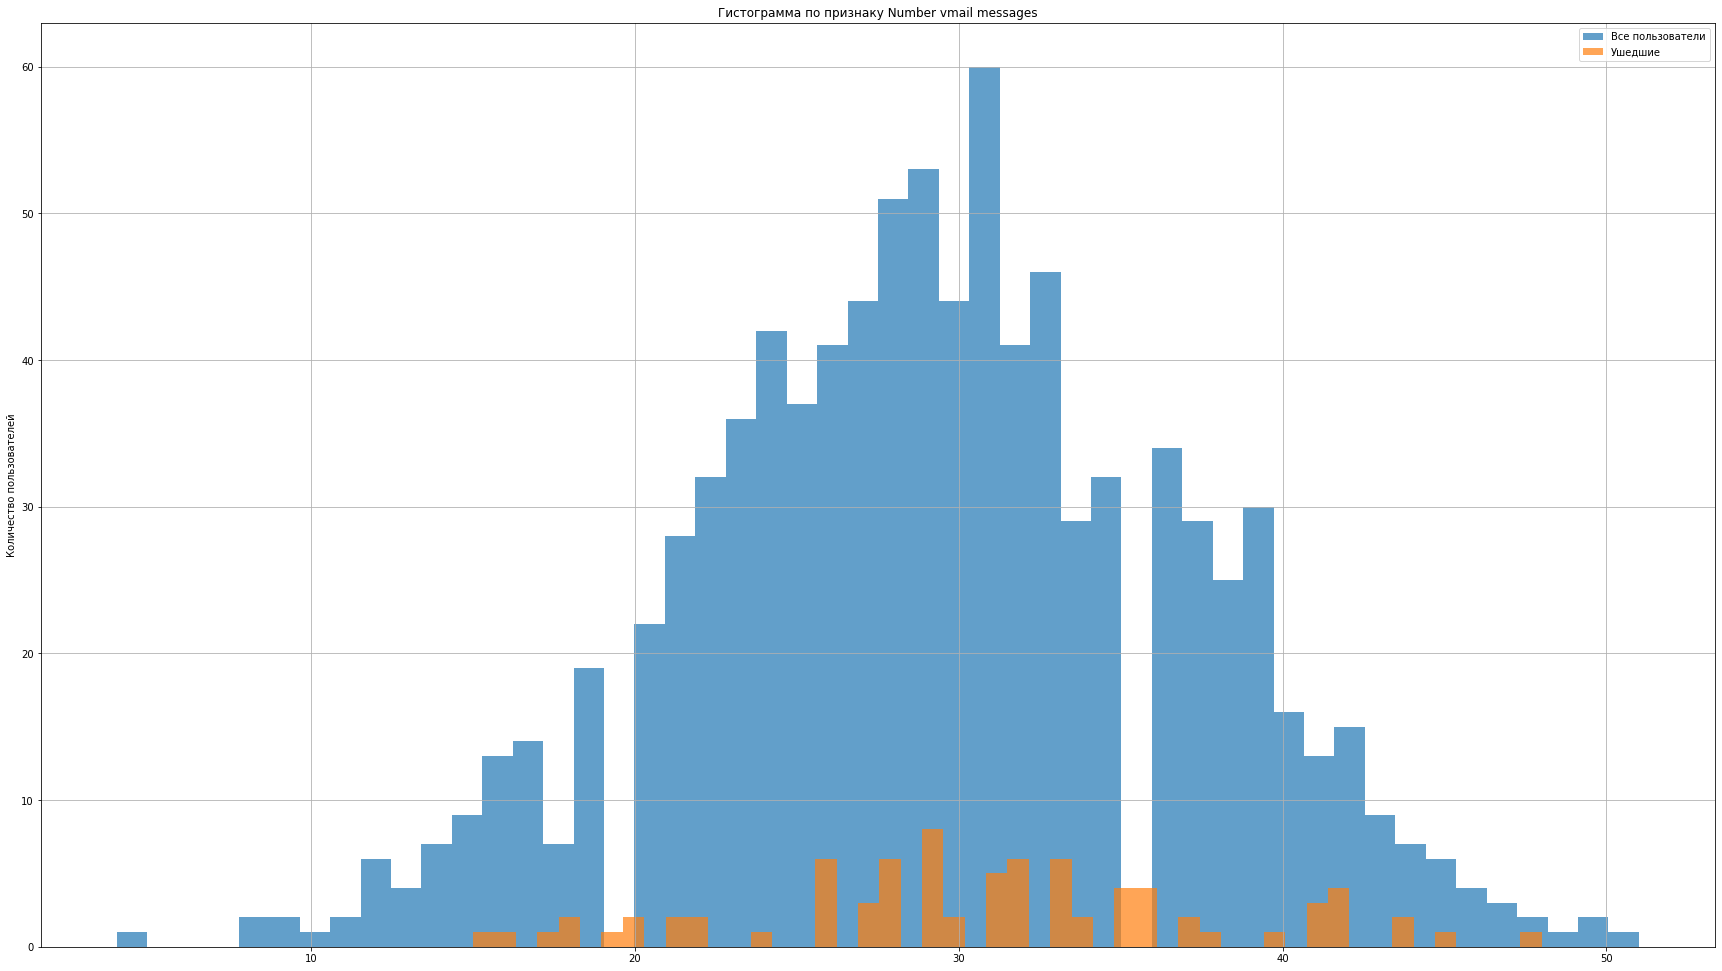

In [11]:
plt.figure(figsize=(30,17))
df[df['Number vmail messages'] != 0]['Number vmail messages'].hist(alpha=0.7, bins=50)
df[df['Number vmail messages'] != 0][df['Churn'] == 1]['Number vmail messages'].hist(alpha=0.7, bins=50)
plt.legend(['Все пользователи', 'Ушедшие'])
plt.title(f'Гистограмма по признаку Number vmail messages')
plt.ylabel('Количество пользователей')
plt.show()

Ничего выделяющегося не видно, единственное - мао данных.

Но судя ещэ по предыдущему распределению (с нулевыми) можно выдвинуть гипотезу, что ушедшие пользователи не пользовались vmail message.

Также посомтрим на распределение по штатам:

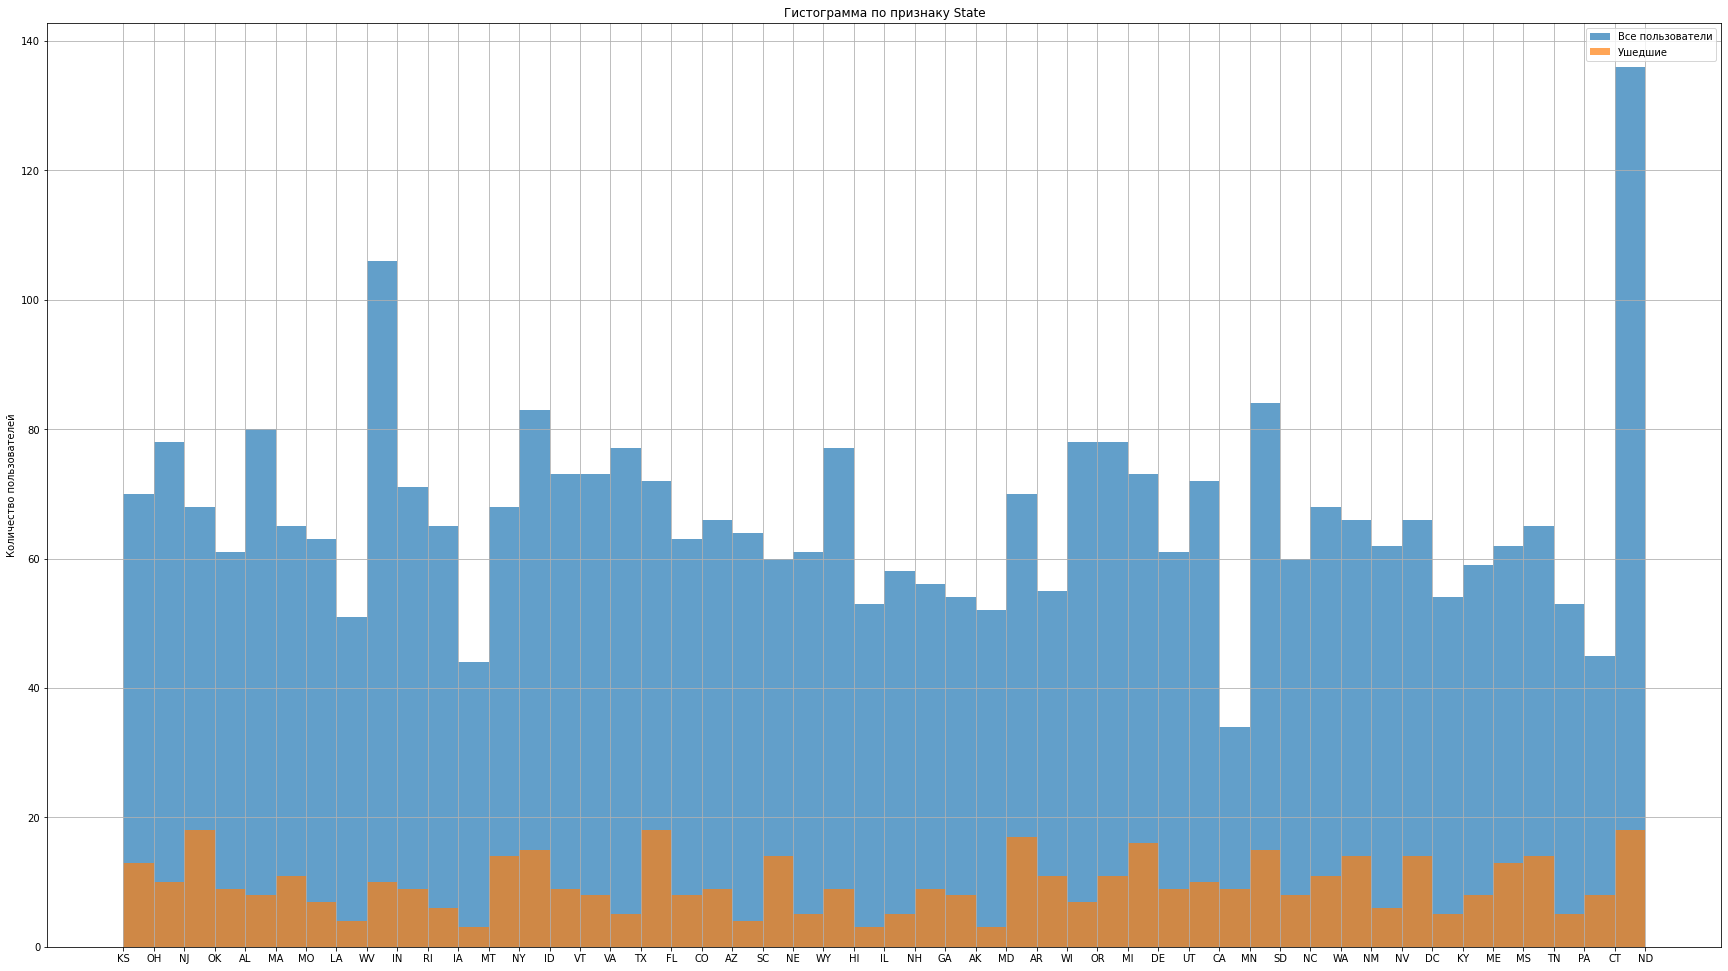

In [12]:
plt.figure(figsize=(30,17))
df['State'].hist(alpha=0.7, bins=50)
df[df['Churn'] == 1]['State'].hist(alpha=0.7, bins=50)
plt.legend(['Все пользователи', 'Ушедшие'])
plt.title(f'Гистограмма по признаку State')
plt.ylabel('Количество пользователей')
plt.show()

Посмотрим на 10 штатов с наибольшим процентом ухода:

In [13]:
table = pd.pivot_table(df, values='Churn', columns=['State'], aggfunc={np.mean, len}).T
table.sort_values('mean', ascending=False).head(10)

,len,mean
State,,
NJ,68.0,0.264706
CA,34.0,0.264706
TX,72.0,0.250000
MD,70.0,0.242857
SC,60.0,0.233333
MI,73.0,0.219178
MS,65.0,0.215385
NV,66.0,0.212121
WA,66.0,0.212121


Можно заметить, что количество пользователей прмиерно одинаковое, но есть выделяющиеся штаты с бОьшим процентом ухода, надо присмотреться к ним и изучить в будущем.

И посмотрим как связаны с друг другом количетсвенные признаки:

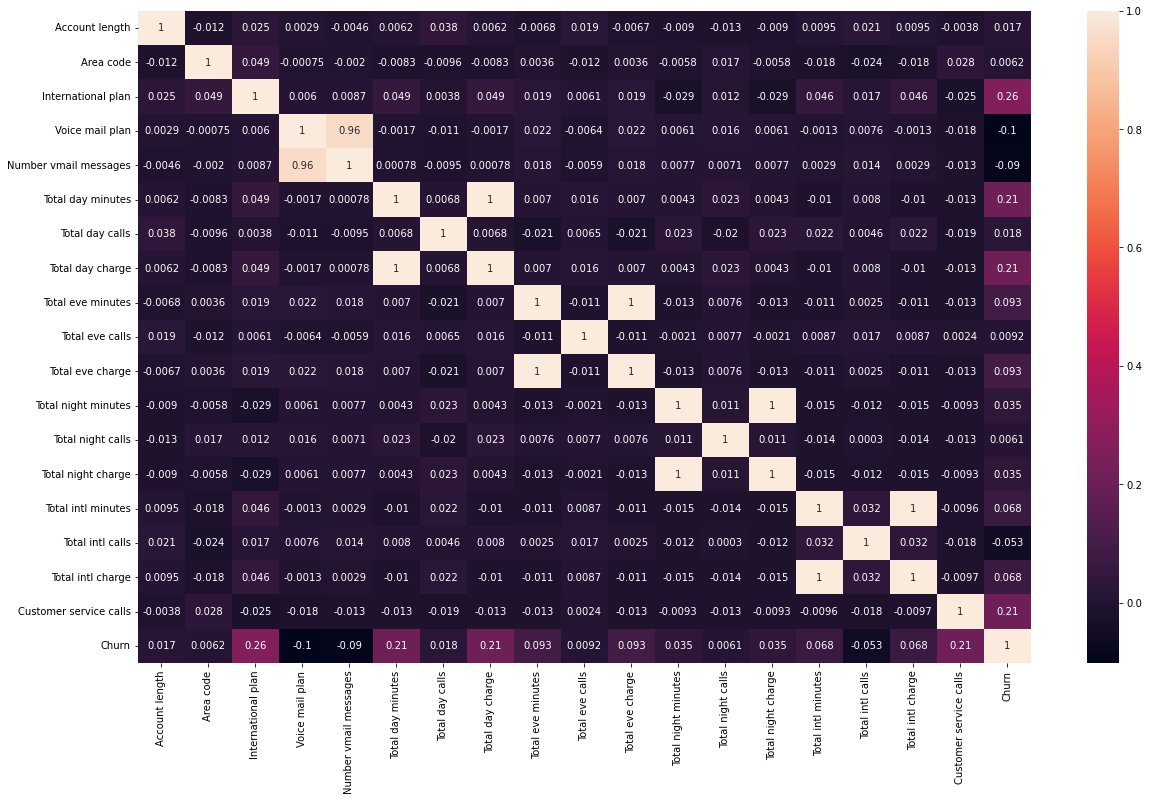

In [14]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

Видим, что некоторые переменные очень хорошо коррелируют, значит будет хватать одной из.

#### Вывод после EDA

У нас есть дисбаланс классов: ~1:6.

Были выдвинуты некоторые гипотезы/замечено следующее:
- Пользователи с тарифом 'зарубежный' уходят чаще.
- Total day minutes: Если пользователь говорил в день по телеыфону много боольше среднего, то он уходи от нас. Возможно, у нас нет тарифа для очень большого количества минут.
- Аналогично, что и прошлое, можно скзаать про признак Total day charge.
- Также можем заметить, что пользователи, которые звонили в сервис более 4 раз, чаще уходили.
- Ушедшие пользователи не пользовались vmail message.
- Есть выделяющиеся штаты с бОьшим процентом ухода, надо присмотреться к ним и изучить в будущем.

### Работа с признаками

In [15]:
model_data = pd.DataFrame()
model_data['International plan'] = df['International plan']
model_data['Voice mail plan'] = df['Voice mail plan']

model_data['Total day minutes'] = df['Total day minutes']
model_data['Total eve minutes'] = df['Total eve minutes']
model_data['Total night minutes'] = df['Total night minutes']
model_data['Total intl minutes'] = df['Total intl minutes']

model_data['Customer service calls'] = df['Customer service calls']

model_data['Churn'] = df['Churn']

In [16]:
model_data.head()

,International plan,Voice mail plan,Total day minutes,Total eve minutes,Total night minutes,Total intl minutes,Customer service calls,Churn
0,0,1,265.1,197.4,244.7,10.0,1,0
1,0,1,161.6,195.5,254.4,13.7,1,0
2,0,0,243.4,121.2,162.6,12.2,0,0
3,1,0,299.4,61.9,196.9,6.6,2,0
4,1,0,166.7,148.3,186.9,10.1,3,0


### Обучение

In [17]:
X = model_data.drop('Churn', axis=1)
Y = model_data['Churn']

In [18]:
logit_mod = sm.Logit(endog=Y, exog=sm.add_constant(X)).fit()
logit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.327003
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3333
Model:                          Logit   Df Residuals:                     3325
Method:                           MLE   Df Model:                            7
Date:                Fri, 31 Mar 2023   Pseudo R-squ.:                  0.2097
Time:                        23:57:54   Log-Likelihood:                -1089.9
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                1.042e-120
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3577      0.509    -16.431      0.000      -9.355      -7.361
International plan         2.0219      0.144     13.999      0.000       1.739       2.305
Voice mail plan           -0.9432      0.144     -6.528      0.000      -1.226      -0.660
Total day minutes          0.0129      0.001     11.948      0.000       0.011       0.015
Total eve minutes          0.0071      0.001      6.260      0.000       0.005       0.009
Total night minutes        0.0036      0.001      3.283      0.001       0.001       0.006
Total intl minutes         0.0842      0.020      4.138      0.000       0.044       0.124
Customer service calls     0.5111      0.039     13.094      0.000       0.435       0.588
==========================================================================================
"""

In [19]:
probit_mod = sm.Probit(endog=Y, exog=sm.add_constant(X)).fit()
probit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.326574
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3333
Model:                         Probit   Df Residuals:                     3325
Method:                           MLE   Df Model:                            7
Date:                Fri, 31 Mar 2023   Pseudo R-squ.:                  0.2108
Time:                        23:57:54   Log-Likelihood:                -1088.5
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                2.526e-121
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.4829      0.261    -17.153      0.000      -4.995      -3.971
International plan         1.1662      0.082     14.264      0.000       1.006       1.326
Voice mail plan           -0.4775      0.075     -6.383      0.000      -0.624      -0.331
Total day minutes          0.0067      0.001     12.055      0.000       0.006       0.008
Total eve minutes          0.0036      0.001      5.955      0.000       0.002       0.005
Total night minutes        0.0019      0.001      3.057      0.002       0.001       0.003
Total intl minutes         0.0422      0.011      3.817      0.000       0.021       0.064
Customer service calls     0.2913      0.021     13.881      0.000       0.250       0.332
==========================================================================================
"""

#### Смотрим на метрики качества: $R^2$, confusion matrix, precision, recall, F1-score, ROC AUC

In [20]:
y_pred_logit = np.where(logit_mod.predict(sm.add_constant(X)) > 0.5, 1, 0)
y_pred_probit = np.where(probit_mod.predict(sm.add_constant(X)) > 0.5, 1, 0)

In [21]:
confusion_matrix(y_true = Y, y_pred=y_pred_logit)

array([[2782,   68],
       [ 391,   92]])

In [22]:
confusion_matrix(y_true = Y, y_pred=y_pred_probit)

array([[2790,   60],
       [ 399,   84]])

In [23]:
TP_logit = np.sum((y_pred_logit == 1) & (Y == 1))
FP_logit = np.sum((y_pred_logit == 0) & (Y == 1))
FN_logit = np.sum((y_pred_logit == 1) & (Y == 0))
TN_logit = np.sum((y_pred_logit == 0) & (Y == 0))

In [24]:
TP_logit, FP_logit, FN_logit, TN_logit

(92, 391, 68, 2782)

In [25]:
TP_probit = np.sum((y_pred_probit == 1) & (Y == 1))
FP_probit = np.sum((y_pred_probit == 0) & (Y == 1))
FN_probit = np.sum((y_pred_probit == 1) & (Y == 0))
TN_probit = np.sum((y_pred_probit == 0) & (Y == 0))

In [26]:
TP_probit, FP_probit, FN_probit, TN_probit

(84, 399, 60, 2790)

In [27]:
f1_score(y_true = Y, y_pred= y_pred_logit)

0.28615863141524106

In [28]:
f1_score(y_true = Y, y_pred= y_pred_probit)

0.2679425837320574

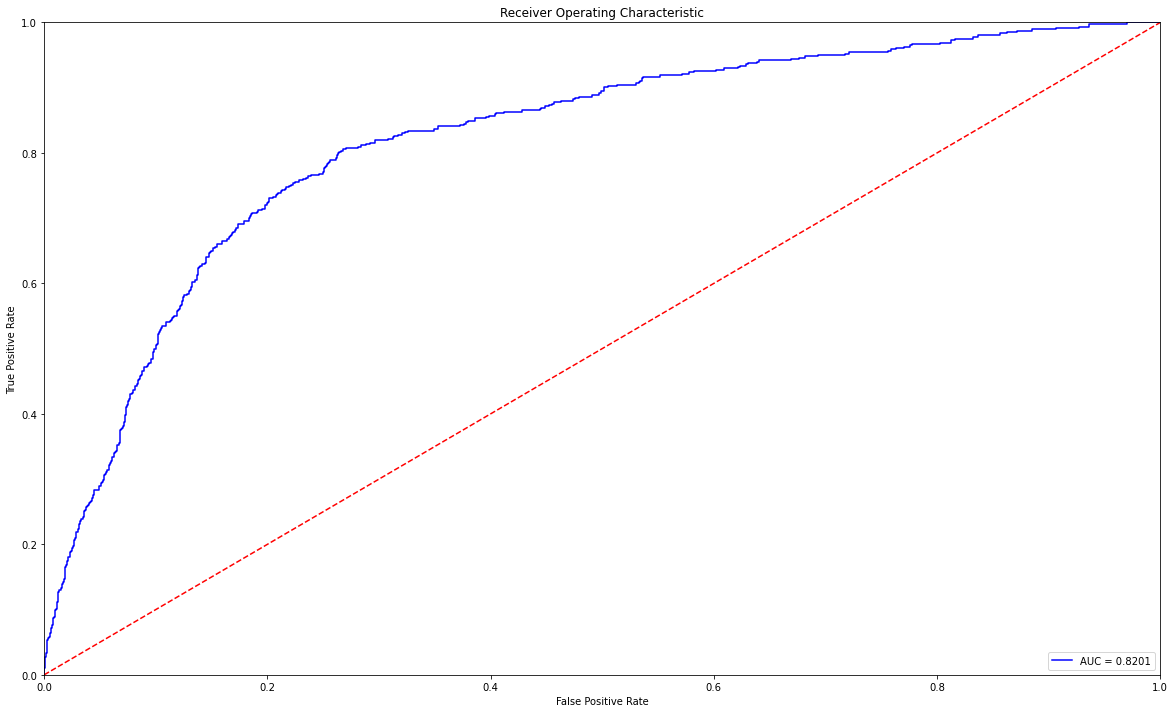

In [29]:
fpr, tpr, threshold = roc_curve(Y, logit_mod.predict(sm.add_constant(X)))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(20, 12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

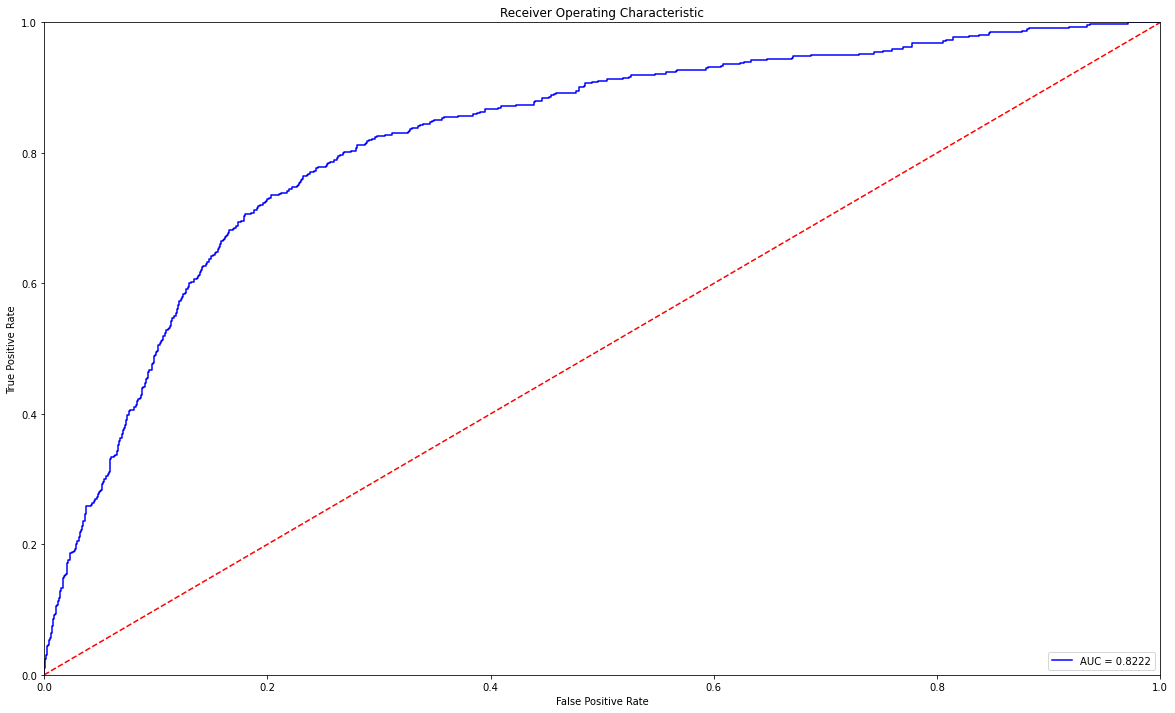

In [30]:
fpr, tpr, threshold = roc_curve(Y, probit_mod.predict(sm.add_constant(X)))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(20, 12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Две модели примерно одинаковы, не факт, что есть значимые различия между ними! 

Но, мне кажется, было бы лучше выбрать ту модель, которая лучше определеяет TP и FP. Поэтому сделаем выбор в сторону logit модели.

### Профиль среднего клиента

Чет не очент понятно что это такое. 

### Предсказания

Делим на тестовую и обучающую:

In [31]:
features_train, features_test, target_train, target_test = train_test_split (
    X, 
    Y, 
    test_size=0.2, 
    random_state=310222
)

Масштабируем:

In [32]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame (
    
    scaler.transform(features_train), 
    features_train.index, 
    features_train.columns
)

features_test = pd.DataFrame (
    
    scaler.transform(features_test), 
    features_test.index, 
    features_test.columns
    
)

Запустим GridSearchCV:

In [33]:
LR = LogisticRegression(random_state=310323, solver='liblinear')

parametrs = { 'penalty': ['l1','l2'],
            'C': [0.001,0.01,0.1,1,10,100,1000]}

grid = GridSearchCV(LR, parametrs, cv=10, scoring='roc_auc')
grid.fit(features_train, target_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=310323,
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

Лучшие параметры:

In [34]:
grid.best_params_

{'C': 0.001, 'penalty': 'l2'}

Лучший score:

In [35]:
grid.best_score_

0.8136997774463148

### Провоерка на тестовой

In [36]:
best_model = LogisticRegression(random_state=310323, penalty='l2', C=0.001, solver='liblinear')
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)

In [37]:
f1_score(target_test, predictions, average='macro')

0.6426176213840643

In [38]:
def plot_ROC_AUC(answers, model):
    answers = model.predict_proba(data_test_features)
    answers = answers[:, 1]
    
    lr_auc = roc_auc_score(data_test_target, answers)
    print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
    
    fpr, tpr, treshold = roc_curve(data_test_target, answers)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

# №3 (60 баллов)

- Ладно, пришла пора для чего более сложного
- В этой задаче вы сами все решаете. Более того, у вас будут даже чужие ноутбуки
- Если вы проведете такой же анализ, что и выше, то балл за это задание будет равен 10/40
- Чтобы получить максимальный балл за это задание, то вам нужно будет провести полноценное исследование

- Итак, представьте себе следующую ситуацию
- Вы участвуете в создании продукта/модели по предсказанию инсульта 
- Вы - главный аналитик, который отвечает за создание модели и презентацию ее результатов
- Проблема в том, что вы единственный аналитик в команде. Все остальные члены команды **не имеют математического бэкграунда, они не знают никаких моделей, они никогда не занимались программированием**. Они все медики.
- Вы знаете, что для тестривания модели на первом этапе подойдет [этот](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) замечательный датасет. Там есть примеры различного анализа и моделей
- Но вы не можете просто взять примеры оттуда:
    - Во-первых, ваша модель должна быть логистической или пробит 
    - Во-вторых, посмотрите на то, как меняется вероятность инсульта в зависимости от характеристик пациента
    - В-третьих, подумайте над тем, как можно поменять/улучшить эту модель, чтобы обеспечить **наилучшее предсказание**. Подумайте, какую метрику вы будете использовать для этой задачи. Обоснуйте выбор метрики.
- Еще важный момент. Вы отправите, получившееся исследование команде, поэтому оно не должно быть большим (время на прочтение и понимание того, что происходит, не должно занимать более 10-15 минут). Помните, что у команды есть и другие задачи, поэтому позаботьтесь, чтобы исследование было:
    - Структурированным. Можете использовать [классический](https://blogs.lse.ac.uk/impactofsocialsciences/2018/05/21/writing-a-page-turner-how-to-tell-a-story-in-your-scientific-paper/) подход к научному исследованию и добавить то, как делают [консультанты](https://strategyu.co/mckinsey-structured-problem-solving-secrets/)
    - Отвечало на поставленную задачу
    - Было самодостаточным (в одном jupyter файле, проще говоря)
    - Воспроизводимым (увижу, что явно не прописываете `seed`, если/где надо, поставлю 0 за это задание)
    - Было не стыдно показать другим людям (если графики будут без подписей осей и названия, как минимум, поставлю 0)